# Este notebook trata con el problema de clasificación de sobrevivenvia o no sobrevivencia de pasajeros del Titanic, un problema desafío clásico de Kaggle.
# Se dispone de un conjunto de entrenamiento y otro de testeo cuyos resultados posee Kaggle. Se realizan las etapas de análisis exploratorio, preprocesamiento y modelado. Finalmente se evalúa el modelo mediante la métrica de Jaccard y se hace la predicción que se envía a Kaggle para su evaluación. El método de clasificación usado es Decision trees. 
# Este notebook obtuvo un  score de 0.77033 en Kaggle ( aprox. top 40% en el score total de participantes). 

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Abriendo archivos de entrenamiento y testeo

In [226]:
data_train=pd.read_csv('C:/Users/MAURICIO/Desktop/train.csv')
data_test=pd.read_csv('C:/Users/MAURICIO/Desktop/test.csv')

In [227]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [228]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**Número de registros y columnas en train y test:**

In [229]:
data_train.shape, data_test.shape

((891, 12), (418, 11))

La columna Survived en data_test evidentemente no está, pues hay que predecirla.

## Visualización datos

###  Gráfico embarcados/sobrevivientes según sexo.

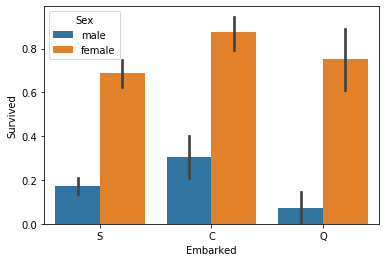

In [230]:
sns.barplot(x='Embarked',y='Survived',hue='Sex',data=data_train)

Claramente, el sexo del pasajero es una variable predictiva importante en la sobrevivencia. En los tres tipos de embarques
sobreviven mucho más mujeres que hombres. Por otro lado, el embarque C es en donde sobreviven tanto más hombres que mujeres.

### Gráfico clase (1°, 2°, 3°) v/s sobrevivientes según sexo

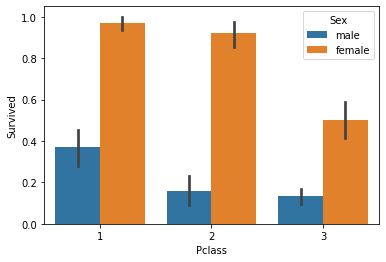

In [231]:
sns.barplot(x='Pclass',y='Survived',hue='Sex',data=data_train)

El sexo de los pasajeros sigue siendo importante con respecto a la clase(1,2 o 3).Se ve también que el número 
de sobrevivientes en cada sexo va disminuyendo con la clase.Se ve mejor en un gráfico de puntos:

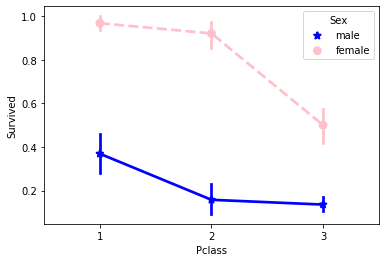

In [232]:
sns.pointplot(x='Pclass',y='Survived',hue='Sex',data=data_train, 
              palette={'male':'blue','female':'pink'},markers=['*','o'],linestyles=['-','--'])

Luego,aparte del sexo, la clase es evidentemente una buena variable predictiva de sobrevivencia.

### Gráfico edad v/s sobrevivientes

Primero formamos  cinco bins  con la variable edad: niños, jóvenes, tercera edad.

In [233]:
bins=np.linspace(min(data_train['Age']),max(data_train['Age']),5)
group_names=['niños','jovenes','adultos','tercera edad']
data_train['Age_bins']=pd.cut(data_train['Age'],bins,labels=group_names,include_lowest=True)

In [234]:
bins


array([ 0.42 , 20.315, 40.21 , 60.105, 80.   ])

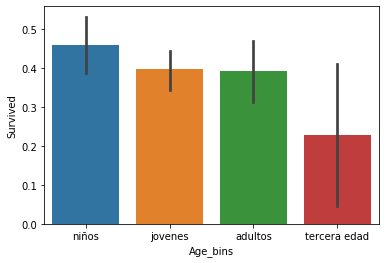

In [235]:
sns.barplot(x=data_train['Age_bins'],y=data_train['Survived'],data=data_train)

Podemos ver que a mayor edad, menor es la sobrevivencia. La edad es otra de nuestras variables predictivas.

Notemos por otro lado, que las variables Embarked y Pclass están relacionadas. Cada clase de pasajeros embarca por su propia
puerta. Así que sólo consideraremos la variable Pclass. Además, eliminaremos las variables que consideramos no útiles para efectos de predecir sobrevivencia: Ticket,Name,Cabin,PassengerId:


In [236]:
data_train.drop(['Ticket','Name','Embarked','Cabin','PassengerId','Age_bins'],axis=1,inplace=True)
data_test.drop(['Ticket','Name','Embarked','Cabin'],axis=1,inplace=True)

In [237]:
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


### Valores faltantes (Missing Data)

Veamos si hay valores indefinidos (NaN) en data_train y data_test:

In [238]:
data_train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

In [239]:
data_test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
dtype: int64

Hay 177 valores faltantes en data_train en la variable edad y 86 en data_test.
Veamos el porcentaje 

In [240]:
177/data_train.shape[0]*100, 86/data_test.shape[0]*100

(19.865319865319865, 20.574162679425836)

Así que hay aproximadamente un 20% de valores faltantes en la columna Age tanto en data_tetst como en data_train. No nos arriegaremos a eliminarlos y los sustituiremos por el valor más frecuente de la columna.

In [241]:
data_train['Age'].value_counts().head()

24.0    30
22.0    27
18.0    26
19.0    25
30.0    25
Name: Age, dtype: int64

Vemos que la edad más frecuente es 24 años.

In [242]:
data_train['Age'].fillna(24.00,inplace=True)

In [243]:
data_test['Age'].value_counts().head()

24.0    17
21.0    17
22.0    16
30.0    15
18.0    13
Name: Age, dtype: int64

In [244]:
data_test['Age'].fillna(24.00,inplace=True)

In [245]:
data_test['Fare'].value_counts().head()

7.7500     21
26.0000    19
8.0500     17
13.0000    17
7.8958     11
Name: Fare, dtype: int64

In [246]:
data_test['Fare'].fillna(7.75,inplace=True)

### Variables categóricas a numéricas

Convertimos la variable Sex a numérica en data_test y data_train:

In [247]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le_train=le.fit(data_train['Sex'])
le_test=le.fit(data_test['Sex'])
data_train['Sex']=le_train.transform(data_train['Sex'])
data_test['Sex']=le_test.transform(data_test['Sex'])


In [248]:
data_train.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


### Normalización

Ahora procedemos a normalizar las columnas Age y Fare para un mejor funcionamiento del algoritmo de modelado(entrenamiento):

In [249]:
X1=data_train[['Age','Fare']]
X2=data_test[['Age','Fare']]
data_train[['Age','Fare']]=preprocessing.StandardScaler().fit(X1).transform(X1.astype(float))
data_test[['Age','Fare']]=preprocessing.StandardScaler().fit(X2).transform(X2.astype(float))

In [250]:
#data_train.head()

### Division en training y test de data_train

Ahora dividimos el dataframe data_train en dos, uno de entrenamiento y otro para testear el modelo predictivo:

In [251]:
from sklearn.model_selection import train_test_split
d=data_train.drop(['Survived'],axis=1)
s=data_train['Survived']
d_train,d_test,s_train,s_test=train_test_split(d,s,test_size=0.20,random_state=11)

In [252]:
d_train.shape,s_train.shape,d_test.shape,s_test.shape

((712, 6), (712,), (179, 6), (179,))

## Modelación

Para predecir sobrevivencia usaremos el algoritmo de clasisficación **Decision Trees** y la métrica de Jaccard para medir performance.

In [253]:
from sklearn.tree import DecisionTreeClassifier
Tree=DecisionTreeClassifier(criterion='entropy',max_depth=4)
Tree.fit(d_train,s_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [254]:
Predtree=Tree.predict(d_test)

### Evaluación Modelo

In [255]:
from sklearn import metrics
print('Accuracy:',metrics.accuracy_score(s_test,Predtree))

Accuracy: 0.8715083798882681


**Una vez evaluado el modelo, volvemos a generarlo, esta vez usando todo el archivo data_train,para poder utilizarlo otra vez:**

In [256]:
X=data_train.drop(['Survived'],axis=1)
Y=data_train['Survived']
Tree1=DecisionTreeClassifier(criterion='entropy',max_depth=4)
Tree1.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## Predicción Final

Finalmente, hacemos nuestra predicción con data_test:

In [257]:
ids=data_test['PassengerId']
Ysurvived=Tree1.predict(data_test.drop(['PassengerId'],axis=1))


In [258]:
output=pd.DataFrame({'PassengerId':ids,'Survived':Ysurvived})
output.to_csv('TitanicPredict2.csv',index=False)